In [1]:
#load python modules

import xarray as xr
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

# Standard imports
from http.cookiejar import CookieJar
import netrc
from socket import gethostname, gethostbyname
from urllib import request

# Third-party imports
import requests
from tqdm import tqdm

In [2]:
# Standard imports
from http.cookiejar import CookieJar
import netrc
from socket import gethostname, gethostbyname
from urllib import request

# Third-party imports
import requests

class S3List:
    """Class used to query and download from PO.DAAC's CMR API.
    """

    CMR = "cmr.earthdata.nasa.gov"
    URS = "urs.earthdata.nasa.gov"

    def __init__(self):
        self._token = None

    def login(self):
        """Log into Earthdata and set up request library to track cookies.
        
        Raises an exception if can't authenticate with .netrc file.
        """

        try:
            username, _, password = netrc.netrc().authenticators(self.URS)
        except (FileNotFoundError, TypeError):
            raise Exception("ERROR: There not .netrc file or endpoint indicated in .netrc file.")

        # Create Earthdata authentication request
        manager = request.HTTPPasswordMgrWithDefaultRealm()
        manager.add_password(None, self.URS, username, password)
        auth = request.HTTPBasicAuthHandler(manager)

        # Set up the storage of cookies
        jar = CookieJar()
        processor = request.HTTPCookieProcessor(jar)

        # Define an opener to handle fetching auth request
        opener = request.build_opener(auth, processor)
        request.install_opener(opener)

    def get_token(self, client_id, ip_address):
        """Get CMR authentication token for searching records.
        
        Parameters
        ----------
        client_id: str
            client identifier to obtain token
        ip_address: str
            client's IP address
        """

        try:
            username, _, password = netrc.netrc().authenticators(self.URS)
        except (FileNotFoundError, TypeError) as error:
            raise Exception("ERROR: There not .netrc file or endpoint indicated in .netrc file.")

        # Post a token request and return resonse
        token_url = f"https://{self.CMR}/legacy-services/rest/tokens"
        token_xml = (f"<token>"
                        f"<username>{username}</username>"
                        f"<password>{password}</password>"
                        f"<client_id>{client_id}</client_id>"
                        f"<user_ip_address>{ip_address}</user_ip_address>"
                    f"</token>")
        headers = {"Content-Type" : "application/xml", "Accept" : "application/json"}
        self._token = requests.post(url=token_url, data=token_xml, headers=headers) \
            .json()["token"]["id"]

    def delete_token(self):
        """Delete CMR authentication token."""

        token_url = f"https://{self.CMR}/legacy-services/rest/tokens"
        headers = {"Content-Type" : "application/xml", "Accept" : "application/json"}
        try:
            res = requests.request("DELETE", f"{token_url}/{self._token}", headers=headers)
            return res.status_code
        except Exception as e:
            raise Exception(f"Failed to delete token: {e}.")

    def run_query(self, shortname, provider, temporal_range, bbox):
        """Run query on collection referenced by shortname from provider."""

        url = f"https://{self.CMR}/search/granules.umm_json"
        params = {
                    "provider" : provider, 
                    "ShortName" : shortname, 
                    "token" : self._token,
                    "scroll" : "true",
                    "page_size" : 2000,
                    "sort_key" : "start_date",
                    "temporal" : temporal_range,
                    "bounding_box": bbox,
                    "page_size": 2000,
                }
        res = requests.get(url=url, params=params)        
        coll = res.json()
        return [url["URL"] for res in coll["items"] for url in res["umm"]["RelatedUrls"] if url["Type"] == "GET DATA VIA DIRECT ACCESS"]

    def login_and_run_query(self, short_name, provider, temporal_range, bbox):
        """Log into CMR and run query to retrieve a list of S3 URLs."""

        try:
            # Login and retrieve token
            self.login()
            client_id = "podaac_cmr_client"
            hostname = gethostname()
            ip_addr = gethostbyname(hostname)
            self.get_token(client_id, ip_addr)

            # Run query
            s3_urls = self.run_query(short_name, provider, temporal_range, bbox)
            s3_urls.sort()

            # Clean up and delete token
            self.delete_token()            
        except Exception:
            raise
        else:
            # Return list
            return s3_urls

In [3]:
def init_S3FileSystem():
    """
    This routine automatically pull your EDL crediential from .netrc file and use it to obtain an AWS S3 credential through a podaac service accessable at https://archive.podaac.earthdata.nasa.gov/s3credentials
    
    Return:
    =======
    
    s3: an AWS S3 filesystem
    """
    import requests,s3fs
    creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'])
    return s3

In [4]:
def clean_l2p_da(data, qc_threshold, bbox):
    """
    bbox: West,South,East,North
    """
    w, s, e, n = [int(a) for a in bbox.split(',')]
    da = data.drop_vars([#'sst_dtime',
                  #'dt_analysis',
                  'satellite_zenith_angle',
                  'sea_ice_fraction',
                  'sst_gradient_magnitude',
                  'sst_front_position'])
    data_threshold = da.where(da.quality_level>=qc_threshold)
    all_data = data_threshold.stack(pt=('ni','nj')).dropna(dim='pt')
    loc_data = all_data.where(all_data.lat>=s).where(all_data.lat<=n).where(all_data.lon<=e).where(all_data.lon>=w)
    neat_data = loc_data.dropna(dim='pt').reset_index('pt').drop(['ni', 'nj'])
    time = neat_data.time.values
    to_return = neat_data.drop('time').squeeze()
    # to_return['time'] = xr.DataArray(data=np.tile(t, (len(sq.lat))), dims=['pt'])
    to_return['time'] = xr.DataArray(data=(time+to_return['sst_dtime'].values), dims=['pt'])
    return to_return.drop_vars(['sst_dtime'])

In [5]:
s3sys=init_S3FileSystem()

# Required data 
short_name = 'VIIRS_NPP-STAR-L2P-v2.80'
provider = 'POCLOUD'
temporal_range = '2022-07-18T00:00:00Z,2022-07-24T23:59:59Z'
# bbox = "-90,-90,-7,90" #"21,-64,66,-7"
# bbox = "0,-40,5,-35" # SWNE
bbox = "-40,0,-35,5"

viirs_s3 = S3List()
viirs_s3_urls = viirs_s3.login_and_run_query(short_name, provider, temporal_range, bbox)
viirs_s3_urls[0:5]

['s3://podaac-ops-cumulus-protected/VIIRS_NPP-STAR-L2P-v2.80/20220718035000-STAR-L2P_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/VIIRS_NPP-STAR-L2P-v2.80/20220718053000-STAR-L2P_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/VIIRS_NPP-STAR-L2P-v2.80/20220718145000-STAR-L2P_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/VIIRS_NPP-STAR-L2P-v2.80/20220718150000-STAR-L2P_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/VIIRS_NPP-STAR-L2P-v2.80/20220718163000-STAR-L2P_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.80-v02.0-fv01.0.nc']

In [6]:
print('There are %i files.'%len(viirs_s3_urls))

There are 31 files.


In [7]:
# raw_data = xr.open_dataset(s3sys.open(viirs_s3_urls[28]))

In [9]:
# cleaned = clean_l2p_da(raw_data, qc_threshold=4, bbox=bbox)

In [14]:
%%time
cleaned_data = [clean_l2p_da(xr.open_dataset(s3sys.open(url)),
                             qc_threshold=4,
                             bbox=bbox) for url in tqdm(viirs_s3_urls)]


100%|██████████| 31/31 [05:19<00:00, 10.31s/it]

CPU times: user 3min, sys: 48.7 s, total: 3min 49s
Wall time: 5min 19s


In [42]:
concat_data = xr.concat(cleaned_data, dim='pt').set_coords('time').sortby('lon').sortby('lat')

In [60]:
concat_data.where(concat_data.time==concat_data.time[0]).dropna('pt')

<xarray.Dataset>
Dimensions:                  (pt: 163)
Coordinates:
    lat                      (pt) float32 0.0 0.0001221 ... 0.04834 0.04968
    lon                      (pt) float32 -39.93 -39.98 -39.81 ... -39.98 -39.99
    time                     (pt) datetime64[ns] 2022-07-19T03:40:29.500000 ....
Dimensions without coordinates: pt
Data variables:
    dt_analysis              (pt) float32 0.5 0.6 0.6 0.4 ... 0.5 0.4 0.4 0.4
    sea_surface_temperature  (pt) float32 300.3 300.4 300.4 ... 300.3 300.2
    sses_bias                (pt) float32 0.16 0.192 0.208 ... 0.16 0.176 0.16
    sses_standard_deviation  (pt) float32 0.23 0.23 0.23 0.23 ... 0.23 0.23 0.23
    l2p_flags                (pt) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    quality_level            (pt) float32 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
    wind_speed               (pt) float32 7.0 7.0 7.0 7.0 ... 6.8 6.8 6.8 6.8
Attributes: (12/59)
    geospatial_bounds:                        POLYGON(( -52.706  -0.558,  -46...
    geospatial_first_scanline_first_fov_lat:  33.934265
    geospatial_first_scanline_first_fov_lon:  -46.97821
    geospatial_first_scanline_last_fov_lat:   29.02539
    geospatial_first_scanline_last_fov_lon:   -15.067383
    geospatial_last_scanline_first_fov_lat:   -0.5576172
    ...                                       ...
    time_coverage_start:                      20220718T035000Z
    title:                                    VIIRS L2P SST
    uuid:                                     73084fd4-2aab-11ed-985e-ac1f6b5...
    westernmost_longitude:                    -52.705994
    netcdf_version_id:                        4.7.4 of Nov 18 2021 15:43:53 $
    Conventions:                              Conventions = CF-1.7, ACDD-1.3

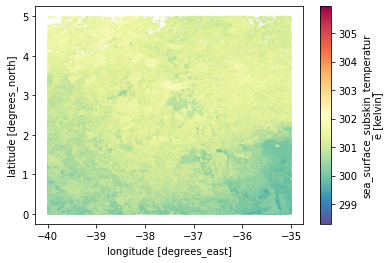

In [26]:
concat_data.plot.scatter(x='lon', y='lat', hue='sea_surface_temperature', cmap='Spectral_r', s=0.01)
plt.show()